# Imports

In [ ]:
import os
import re
import json
import zipfile
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from scipy import sparse
import scikitplot as skplt
from wordcloud import WordCloud

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, brier_score_loss, roc_auc_score, log_loss, make_scorer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV


import warnings
warnings.filterwarnings("ignore")

In [ ]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD, DictionaryLearning, KernelPCA, SparsePCA
from umap import UMAP

cachedStopWords = stopwords.words("english")

# Auxillary functions

In [ ]:
def classifier_f(clf, X_train, y_train, X_test):                               # Fit classifier, then predict labels and probs
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    probs = clf.predict_proba(X_test)
    return y_pred, probs

In [ ]:
def plot_coeffs(coef, feature_names_list, top_features=20):                    # Plot coefficients of words
    
    f, ax = plt.subplots(figsize=(13, 10))
    
    ax.set_title('Most important n-grams for classification', fontsize=20)
    coef = coef.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    ax.barh(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names_list)
    ax.set_yticks(np.arange(2 * top_features))
    ax.set_yticklabels(feature_names[top_coefficients], fontsize=13)
    plt.tight_layout()
    ax.yaxis.grid()
    plt.show()

In [ ]:
def plot_wordcloud(coef, feature_names_list, top_features=100):                # Plot wordclouds
    coef = coef.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    feature_names = np.array(feature_names_list)
    
    fig = plt.figure(figsize=(13, 15), tight_layout=True)
       
    for i, features in enumerate(zip([top_positive_coefficients, top_negative_coefficients], ['Top 50 positive n-grams \n', 'Top 50 negative n-grams \n'])):
        ax = fig.add_subplot(2,1,i+1)
        tags = feature_names[features[0]]
        for idx, tag in enumerate(tags):
            tags[idx] = tag.replace(' ', '_')
        ax.imshow(WordCloud(max_words=50, background_color="dimgray", width=1100, height=500,colormap='seismic').generate(' '.join(tags)), interpolation='bilinear', alpha=0.9)
        ax.set_title(features[1], fontsize=25)
        ax.axis('off')

# Data load

In [ ]:
data = pd.read_csv('LargeMovieReviewDataset.csv')

In [ ]:
data.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [ ]:
#api_token = {"username":"","key":""}
#! pip install -q kaggle
#files.upload()
#! mkdir ~/.kaggle

#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d iarunava/imdb-movie-reviews-dataset
#! mkdir data
#! unzip imdb-movie-reviews-dataset.zip -d train

## Large Movie Review Dataset v1.0

### Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

### Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a score >= 7 out of 10. Thus reviews with
more neutral ratings are not included in the train/test sets. In the
unsupervised set, reviews of any rating are included and there are an
even number of reviews > 5 and <= 5.

### Files

There are two top-level directories [train/, test/] corresponding to
the training and test sets. Each contains [pos/, neg/] directories for
the reviews with binary labels positive and negative. Within these
directories, reviews are stored in text files named following the
convention [[id]_[rating].txt] where [id] is a unique id and [rating] is
the star rating for that review on a 1-10 scale. For example, the file
[test/pos/200_8.txt] is the text for a positive-labeled test set
example with unique id 200 and star rating 8/10 from IMDb. The
[train/unsup/] directory has 0 for all ratings because the ratings are
omitted for this portion of the dataset.

We also include the IMDb URLs for each review in a separate
[urls_[pos, neg, unsup].txt] file. A review with unique id 200 will
have its URL on line 200 of this file. Due the ever-changing IMDb, we
are unable to link directly to the review, but only to the movie's
review page.

# Data read

Here we can see old version of data reading from data-source directly.

In [ ]:
'''train = pd.DataFrame(columns=['name', 'text', 'label'])
pos_path = 'train/aclImdb/train/pos'
for i, txt in enumerate(os.scandir(pos_path)):
    t = open(txt, 'r', encoding='utf-8')
    train.loc[i, 'name'] = txt.name
    train.loc[i, 'text'] = t.read()
    train.loc[i, 'label'] = 1
    t.close()
last = i
neg_path = 'train/aclImdb/train/neg'
for i, txt in enumerate(os.scandir(neg_path)):
    t = open(txt, 'r', encoding='utf-8')
    train.loc[last+i, 'name'] = txt.name
    train.loc[last+i, 'text'] = t.read()
    train.loc[last+i, 'label'] = 0
    t.close()
    
pos_path = 'train/aclImdb/test/pos'
for i, txt in enumerate(os.scandir(pos_path)):
    t = open(txt, 'r', encoding='utf-8')
    test.loc[i, 'name'] = txt.name
    test.loc[i, 'text'] = t.read()
    test.loc[i, 'label'] = 1
    t.close()
last = i
neg_path = 'train/aclImdb/test/neg'
for i, txt in enumerate(os.scandir(neg_path)):
    t = open(txt, 'r', encoding='utf-8')
    test.loc[last+i, 'name'] = txt.name
    test.loc[last+i, 'text'] = t.read()
    test.loc[last+i, 'label'] = 0
    t.close()
test = pd.DataFrame(columns=['name', 'text', 'label'])'''

In [ ]:
Simple data reading
We split our dataframe and shuffle.

In [ ]:
data.duplicated().sum()

418

In [ ]:
data = data.drop_duplicates()

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

<br>

<hr>

<br>

# Preprocessing

In [ ]:
train.loc[0, 'review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
train.loc[11304, 'review']

"Dictated by thin experience (of both life and industry) and no cash Sofia Coppola's early short is almost by necessity an observational piece set on a high school campus. The cast are rather weak and do not benefit from being shot in b&w (it's difficult to tell the characters apart). The sound editing does little to help a simple story of fickle teenage allegiance.<br /><br />Yet there are one or two things to note. Inamongst the inconsistent editing the high school campus is filmed with a balance of aspirant wide and intimate close-up shots. The editing-to-music also creates an interest and momentum (without descent into the netherworld of the Music Video). Coppola clearly made an attempt to vary the pace of the film. The dramatic turn is cut fast and to-the-point and the second act is almost non-existent; we recognise it's actually been played out in tandem with the first, which is the point of the narrator-on-crutches trope (who is an otherwise curiously appended character in that 

## Vectorization

First, try to build a model with the following steps of text processing:
* replacement of abbreviated verbs * is *, * will *, etc. on the full spelling version,
* Stemming with Stemmer Porter and tokenization,
* removal of stop words (from the list of which we will remove the negative particle 'not' in advance, since its presence strongly affects the meaning of the next word)
* removal of all html-markup (by leaving only a set of characters suitable for the regular pattern "[a-zA-Z] +")
* delete all words shorter than 3 characters.
* then we use tf-idf vectorization of words. Take n-grams in the range (1, 2), found in the corpus in no less than 10 texts.

We will check various ways of word processing with the help of three SGDClassifier models; SVM various options for Naive Bayes algorithms. As metrics we will use ROC AUC.

## Stemming

In [ ]:
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"im" :"I am",
"isn't" : "is not",
"its": "it is",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"won't":"will not",
"didn't": "did not"
}

In [ ]:
cachedStopWords.remove('not')

In [ ]:
def tokenize(text):
    min_length = 3
    text = text.lower()
    
    for i, j in appos.items():
        text = text.replace(i, j)
    
    words = map(lambda word: word, word_tokenize(text))
    words = [word for word in words
                  if word not in cachedStopWords]
    tokens = (list(map(lambda token: PorterStemmer().stem(token),
                  words)));
    p = re.compile('[a-zA-Z]+');
    filtered_tokens = list(filter(lambda token:
                  p.match(token) and len(token)>=min_length,
         tokens))
    return filtered_tokens

In [ ]:
def tf_idf(docs):
    tfidf = TfidfVectorizer(tokenizer=tokenize, min_df=10, max_features=20000,
                        use_idf=True, sublinear_tf=True,
                        ngram_range=(2,2))
    tfidf.fit(docs)
    return tfidf

<hr>

In [ ]:
train_lst= list(train.review)

In [ ]:
test_lst = list(test.review)

In [ ]:
vectorizer = tf_idf(train_lst)

In [ ]:
vectorised_train = vectorizer.transform(train_lst)
vectorised_test = vectorizer.transform(test_lst)

### SGDClassifier

In [ ]:
sgd = SGDClassifier(random_state=42, loss='log')
y_pred, y_probs = classifier_f(sgd, vectorised_train, train.sentiment.values, vectorised_test)

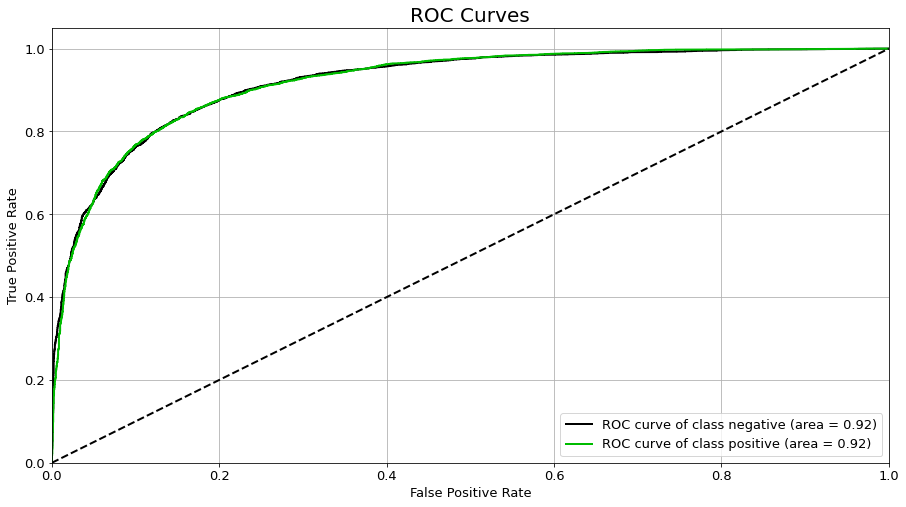

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

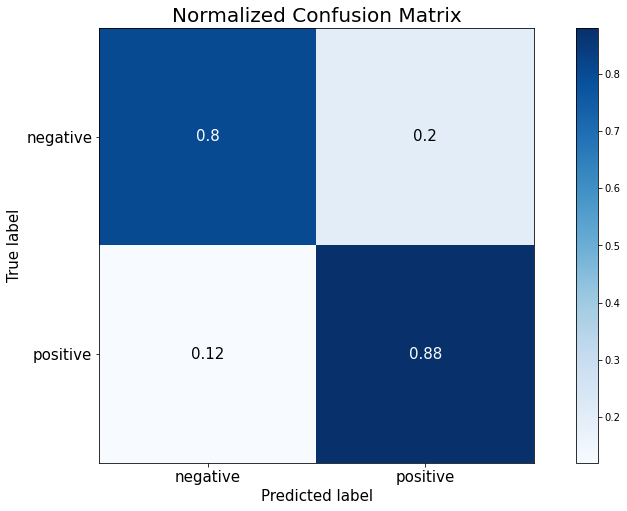

In [ ]:
skplt.metrics.plot_confusion_matrix(test.sentiment.values, y_pred, normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)

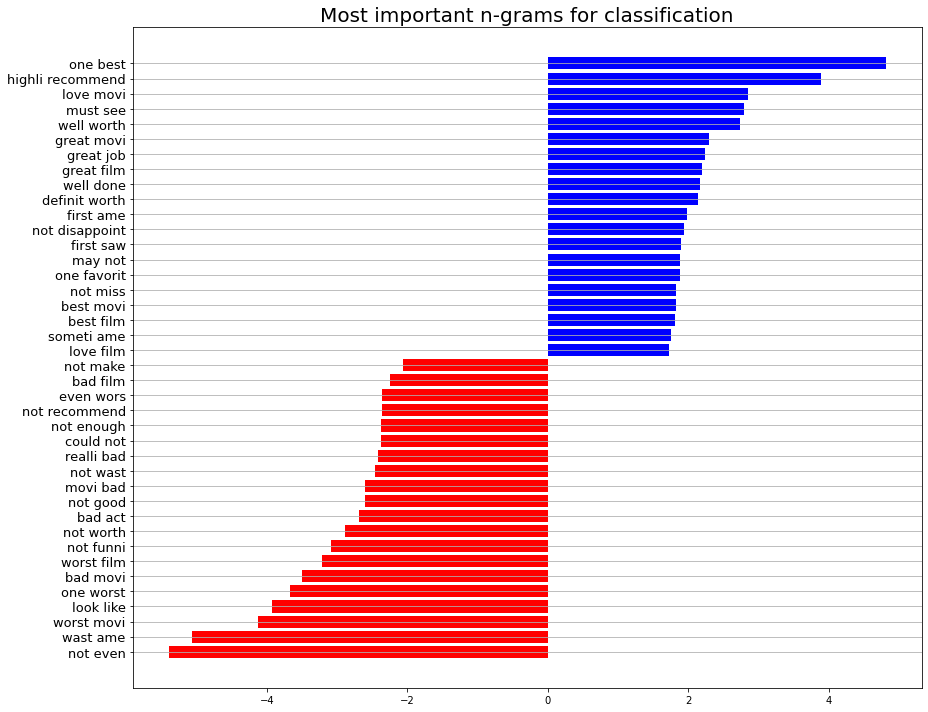

In [ ]:
plot_coeffs(sgd.coef_, vectorizer.get_feature_names())

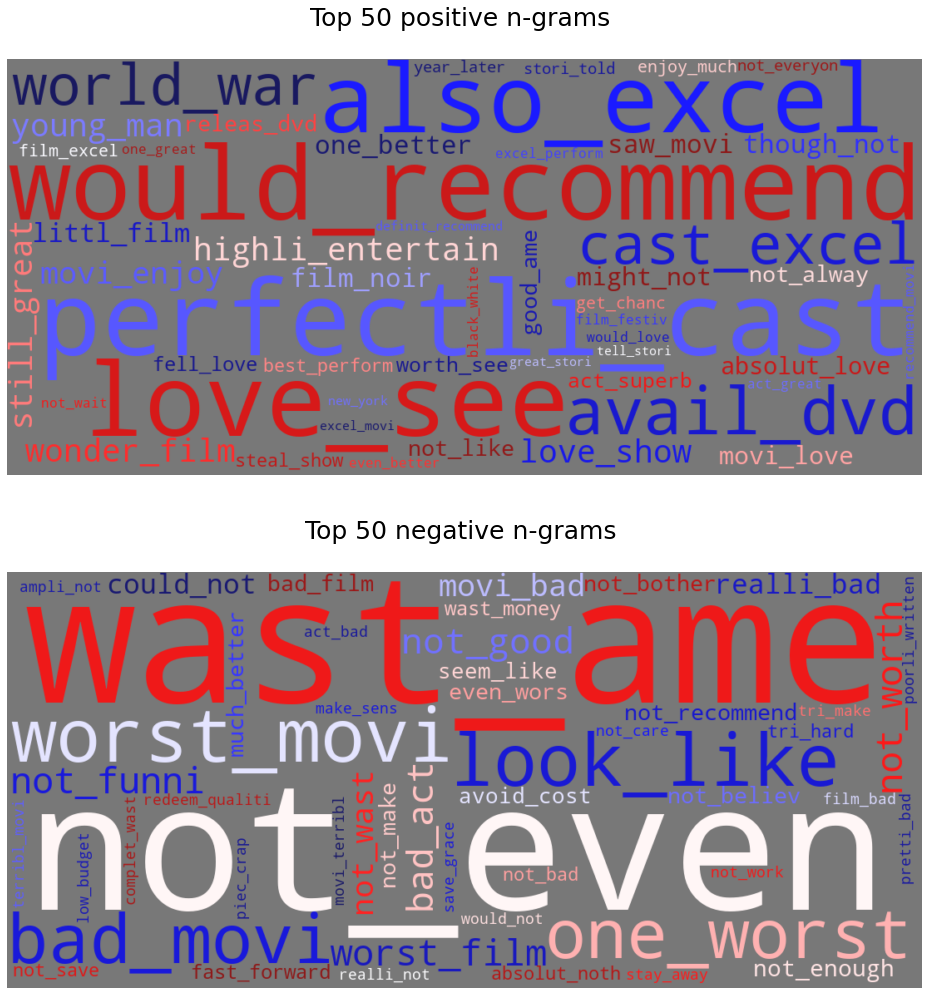

In [ ]:
plot_wordcloud(sgd.coef_, vectorizer.get_feature_names())

<hr>

### LinearSVC

In order to get a probability prediction, wrap LinearSVC in CalibratedClassifierCV.

In [ ]:
svc = CalibratedClassifierCV(LinearSVC(random_state=42))
y_pred, y_probs = classifier_f(svc, vectorised_train, train.sentiment.values, vectorised_test)

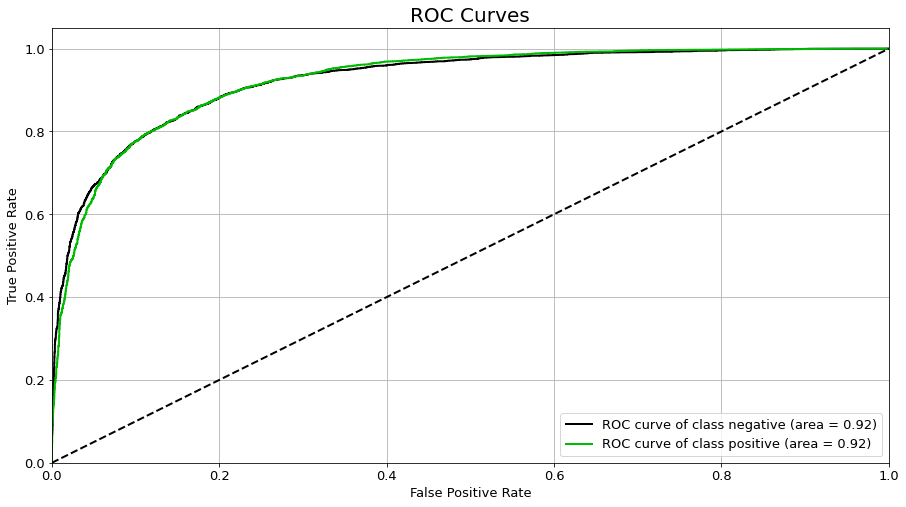

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

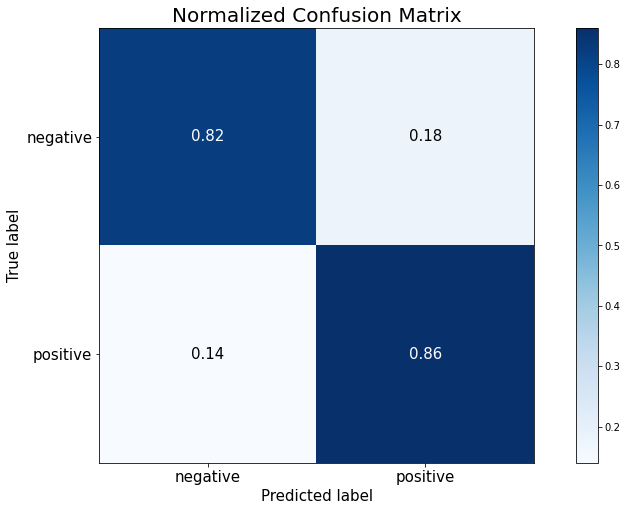

In [ ]:
skplt.metrics.plot_confusion_matrix(test.sentiment.values, y_pred, normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)
plt.show()

Average coefficients for 3 classifiers CalibratedClassifierCV

In [ ]:
coefs = np.zeros((1,20000))
for i in svc.calibrated_classifiers_:
    coefs += np.array(i.base_estimator.coef_)
    coefs = coefs/3

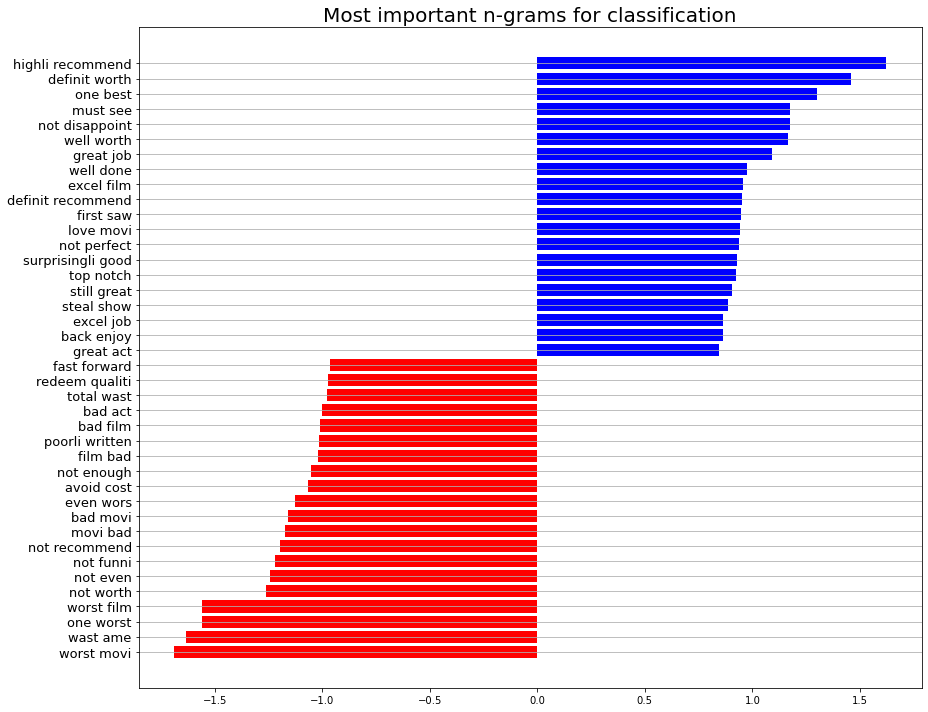

In [ ]:
plot_coeffs(coefs, vectorizer.get_feature_names())

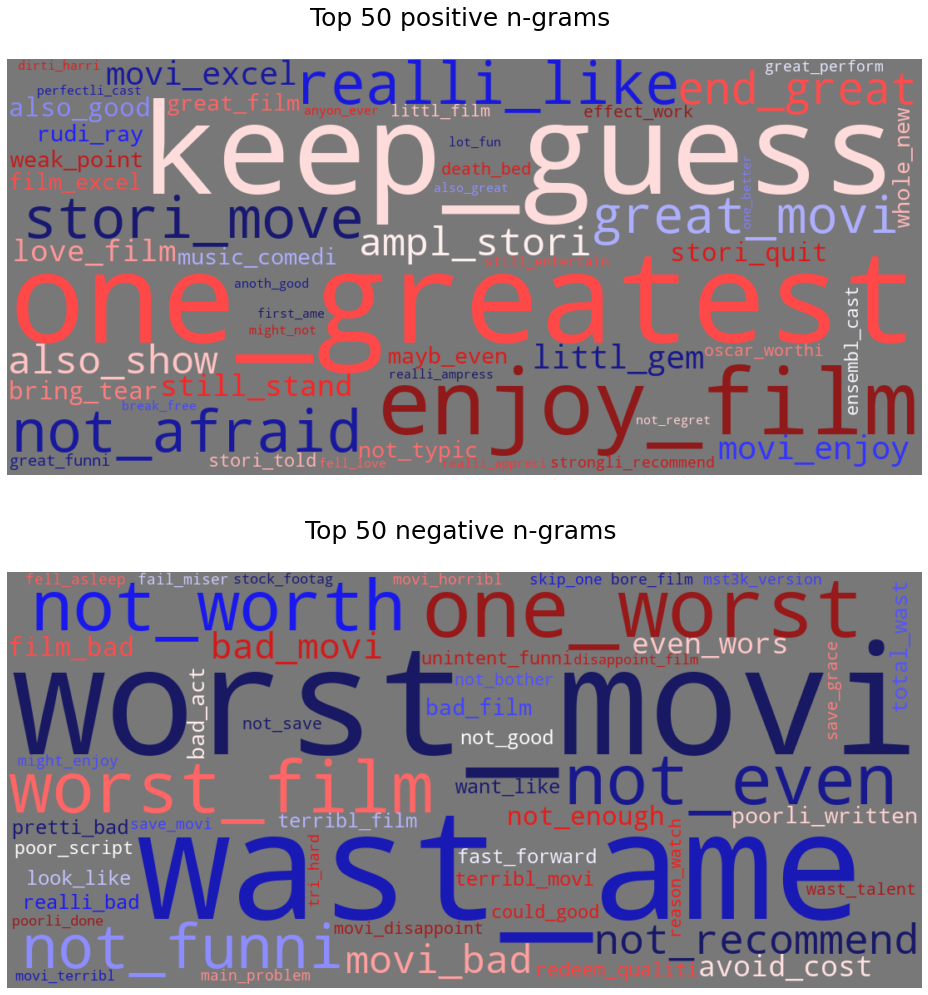

In [ ]:
plot_wordcloud(coefs, vectorizer.get_feature_names())

<hr>

### Naive Bayes

In [ ]:
mnb = MultinomialNB()
y_pred, y_probs = classifier_f(mnb, vectorised_train, train.sentiment, vectorised_test)

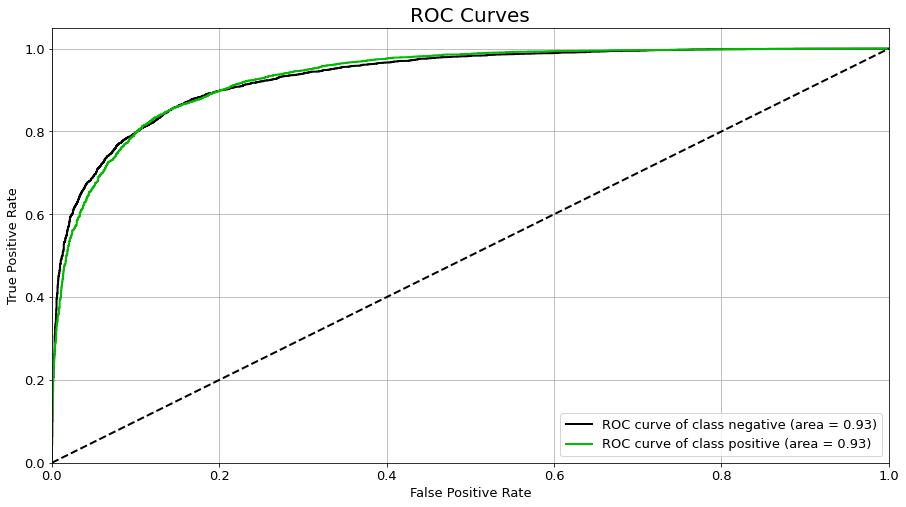

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

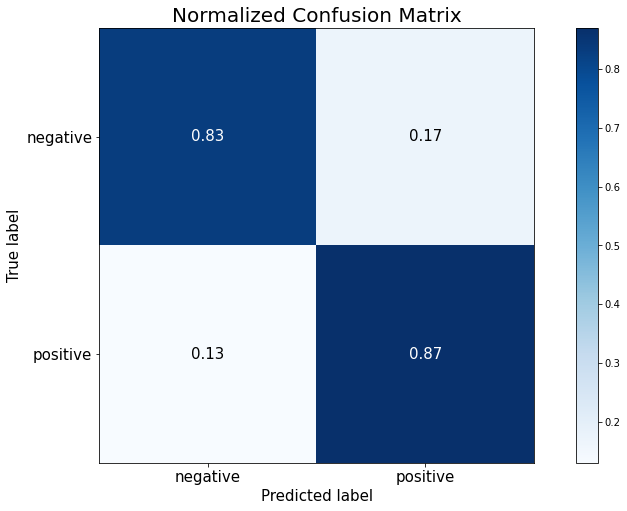

In [ ]:
skplt.metrics.plot_confusion_matrix(test.sentiment.values, y_pred, normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)
plt.show()

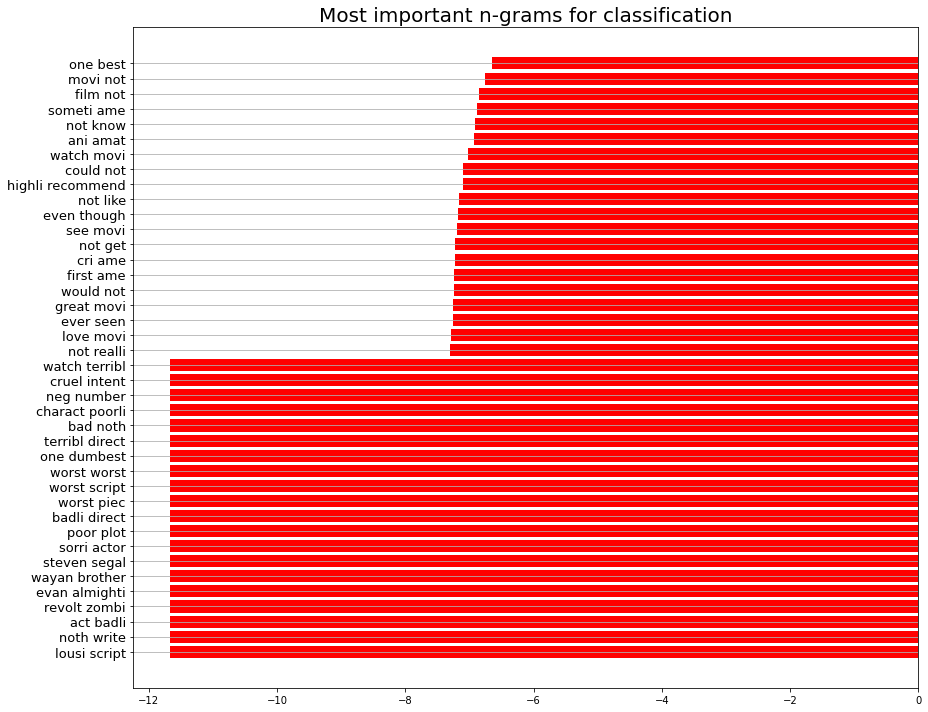

In [ ]:
plot_coeffs(mnb.coef_, vectorizer.get_feature_names())

When using MultinomialNB, all word coefficients are negative, positive word coefficients from negativ only differ in absolute value, and not in sign.

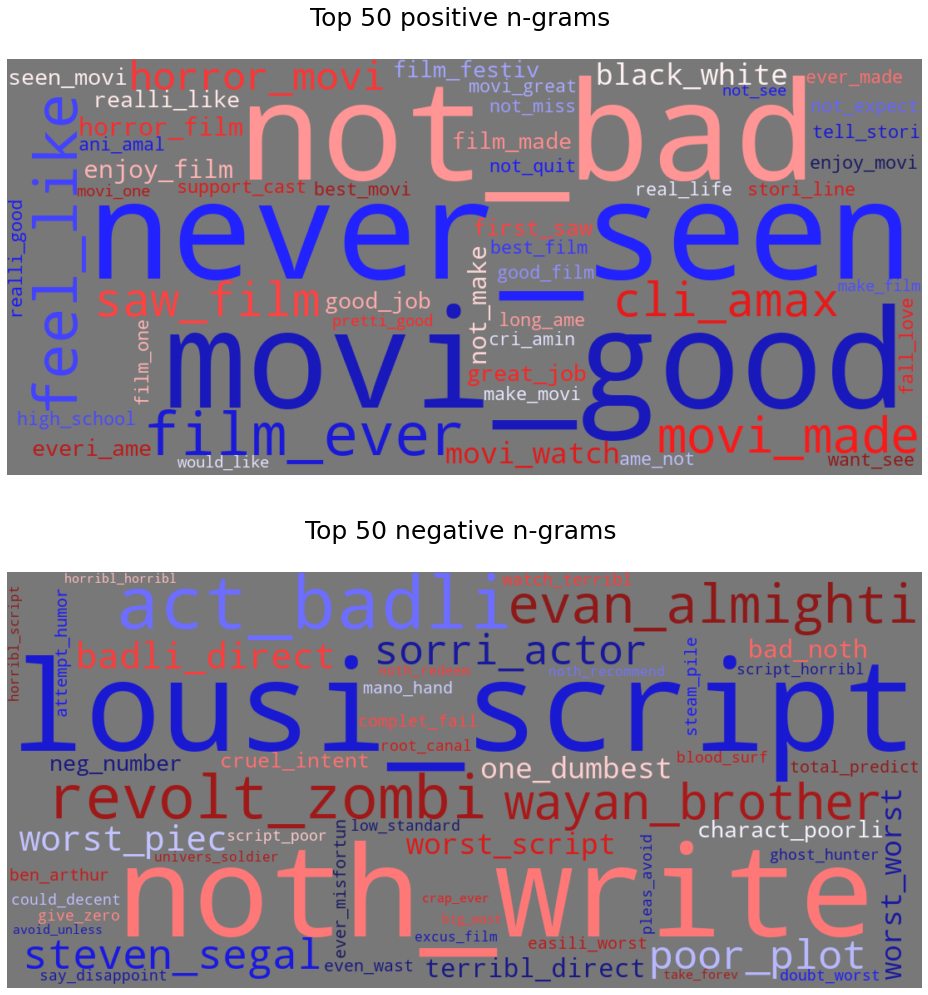

In [ ]:
plot_wordcloud(mnb.coef_, vectorizer.get_feature_names())

Words are much less interpretable

Let's look at other variants of the naive Bayes classifier.

In [ ]:
cnb = ComplementNB()
y_pred, y_probs = classifier_f(cnb, vectorised_train, train.sentiment, vectorised_test)

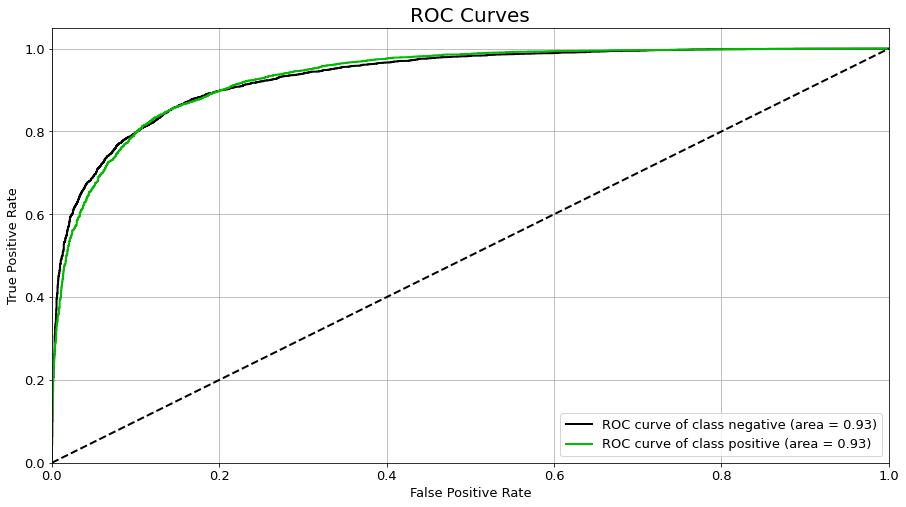

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

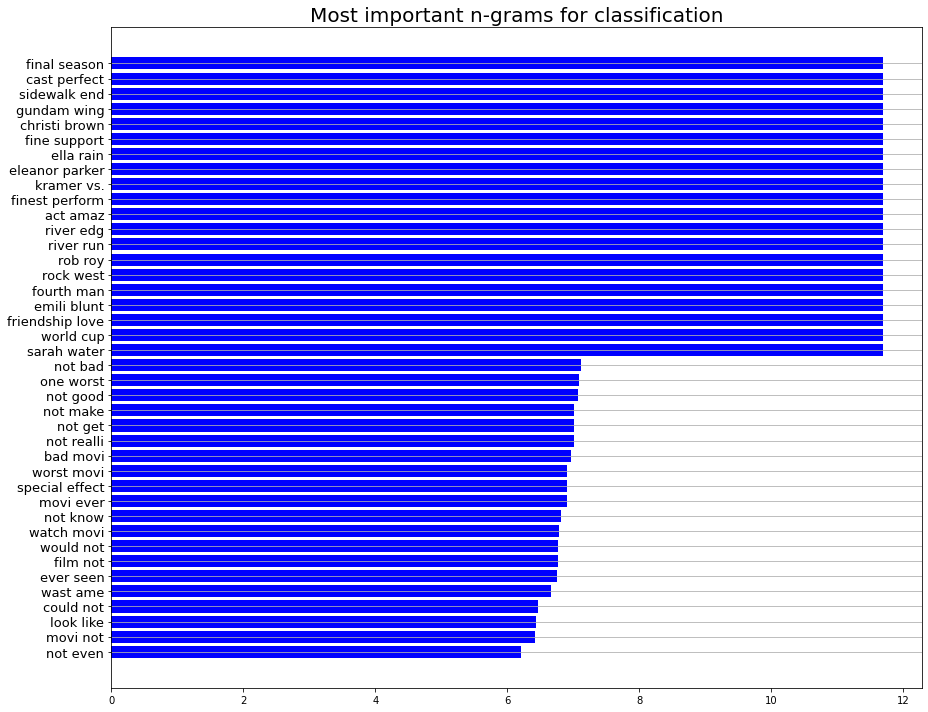

In [ ]:
plot_coeffs(cnb.coef_, vectorizer.get_feature_names())

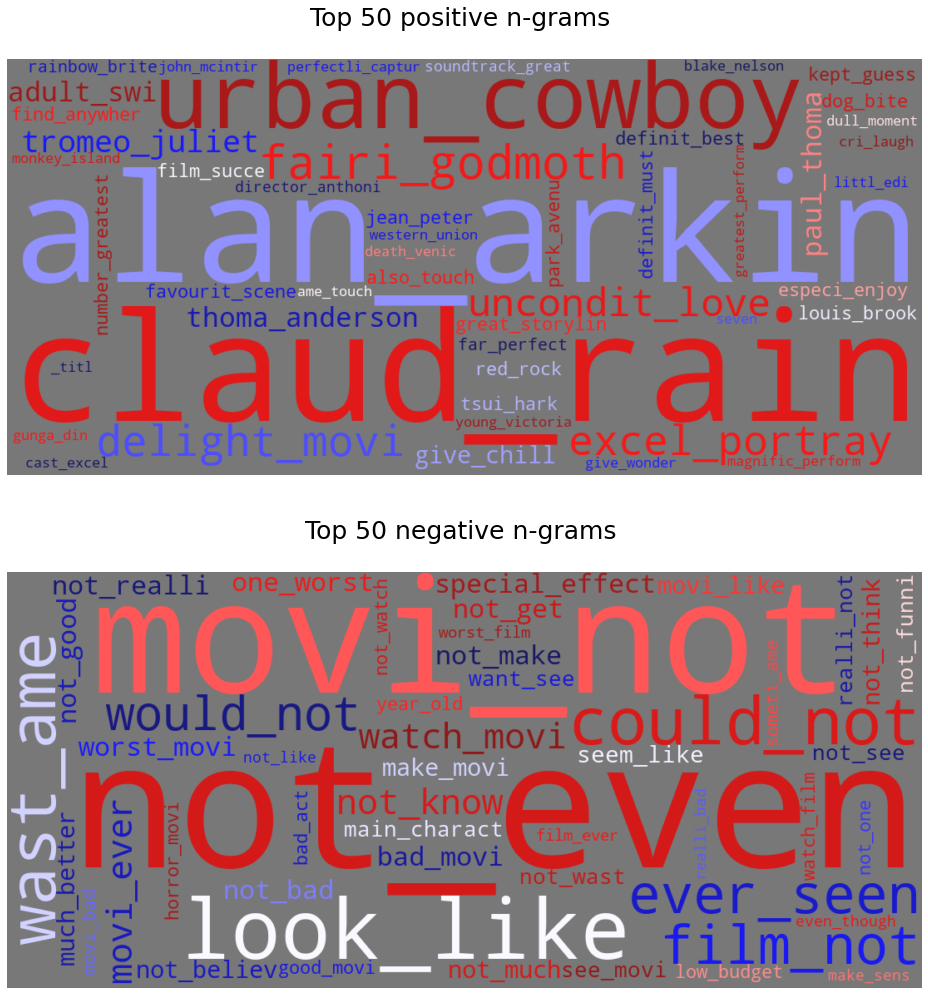

In [ ]:
plot_wordcloud(cnb.coef_, vectorizer.get_feature_names())

BernoulliNB.

In [ ]:
bnb = BernoulliNB()
y_pred, y_probs = classifier_f(bnb, vectorised_train, train.sentiment, vectorised_test)

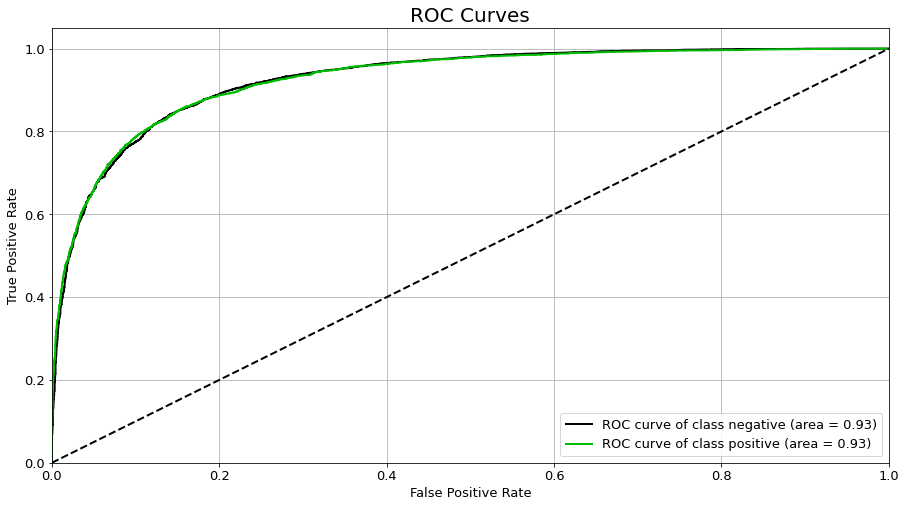

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

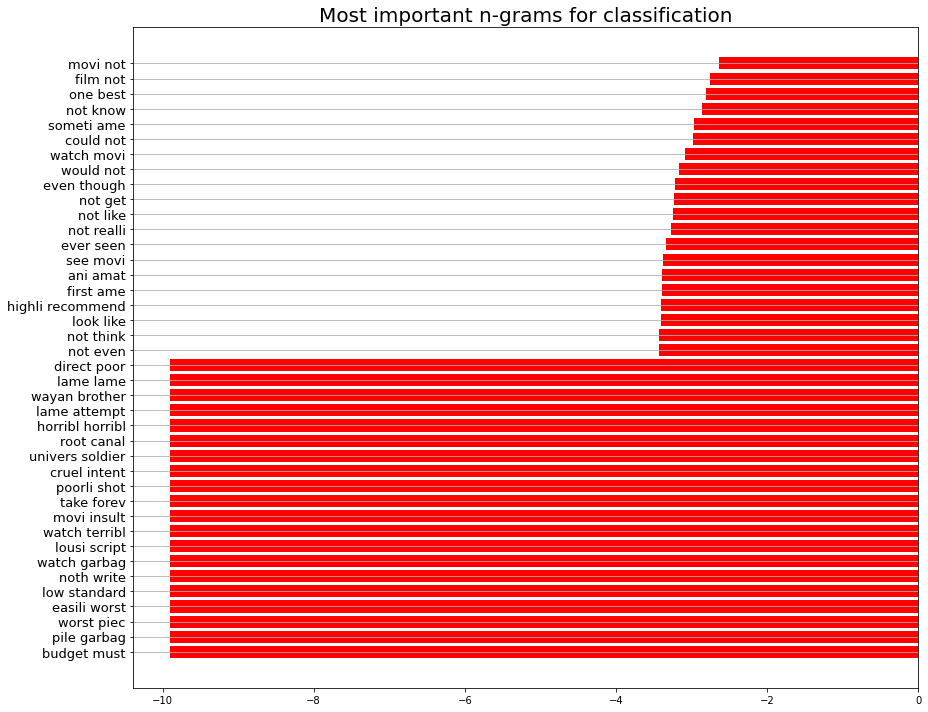

In [ ]:
plot_coeffs(bnb.coef_, vectorizer.get_feature_names())

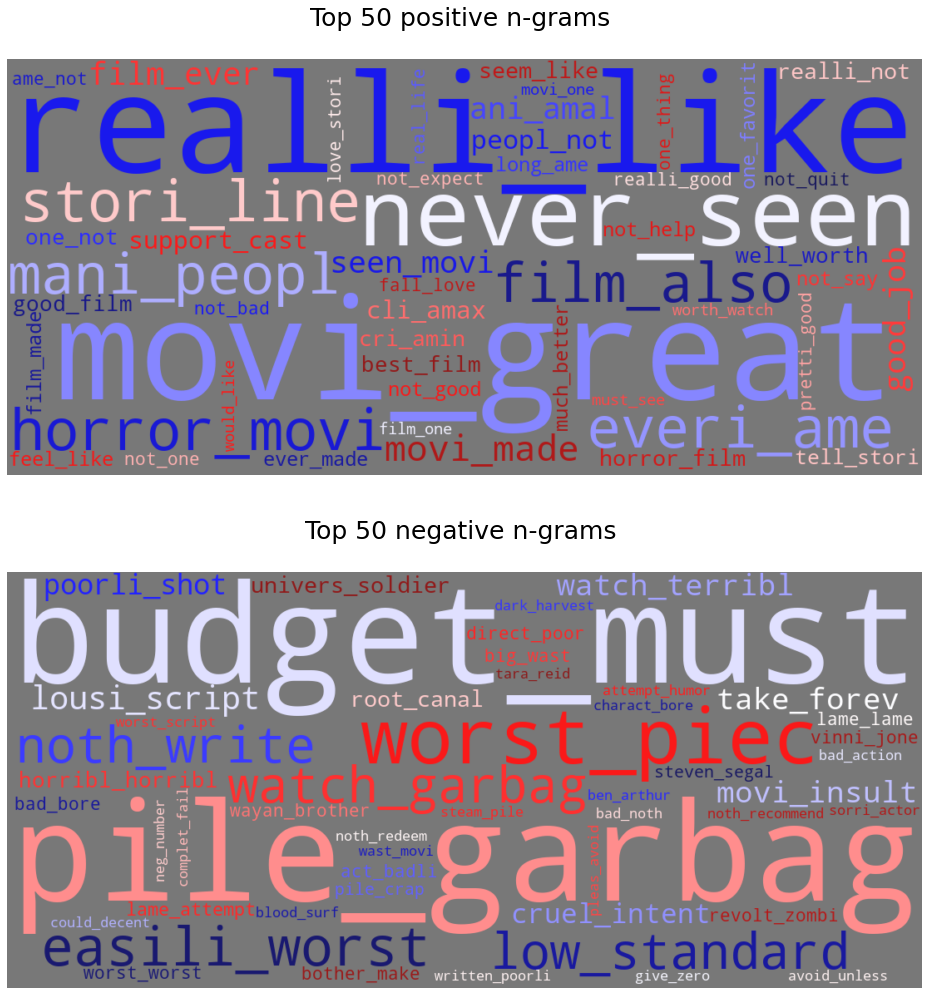

In [ ]:
plot_wordcloud(bnb.coef_, vectorizer.get_feature_names())

* All studied models showed approximately the same indicators of roc auc and indicators of classification accuracy.
* Non-Bayesian algorithms showed a higher quality of interpretability of words important for the algorithm.
* When using stemming, a significant portion of the most important features are 2 grams.

## Lemmatization

We leave all the processing steps the same, but replace the Porter Stemmer with a lemmatizer.


In [ ]:
def tokenize_lem(text):
    wnl = WordNetLemmatizer()
    min_length = 3
    text = text.lower()
    for i, j in appos.items():
        text = text.replace(i, j)
        
    words = [wnl.lemmatize(i,j[0]) if j[0] in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(word_tokenize(text))]
    words = [word for word in words
                  if word not in cachedStopWords]
    p = re.compile('[a-zA-Z]+');
    filtered_tokens = list(filter(lambda token:
                  p.match(token) and len(token)>=min_length,
         words))
    return filtered_tokens

In [ ]:
def tf_idf_lem(docs):
    tfidf = TfidfVectorizer(tokenizer=tokenize_lem, 
                            ngram_range=(1, 2), 
                            max_features=20000)
    tfidf.fit(docs)
    return tfidf

In [ ]:
vectorizer_lem = tf_idf_lem(train_lst)

In [ ]:
vectorizer_lem_train = vectorizer_lem.transform(train_lst)

In [ ]:
vectorizer_lem_test = vectorizer_lem.transform(test_lst)

### SGDClassifier

In [ ]:
sgd = SGDClassifier(random_state=42, loss='log')
y_pred, y_probs = classifier_f(sgd, vectorizer_lem_train, train.sentiment.values, vectorizer_lem_test) 

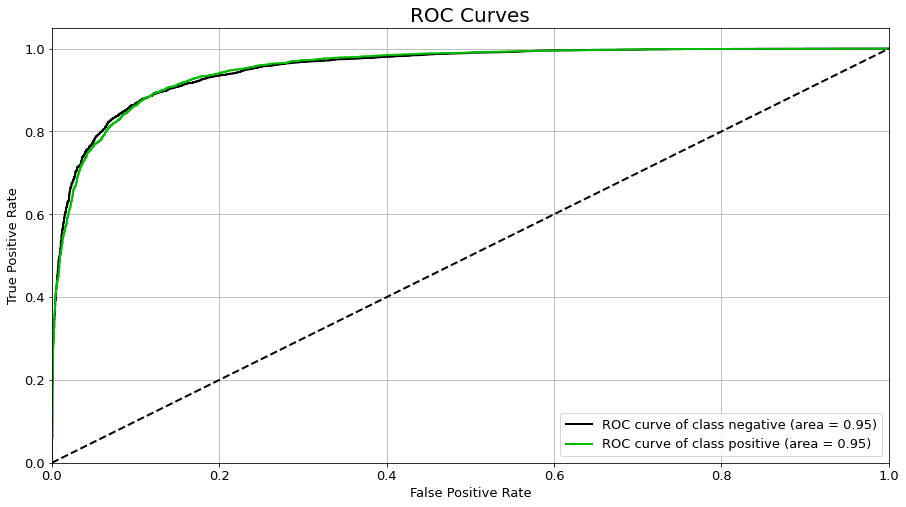

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

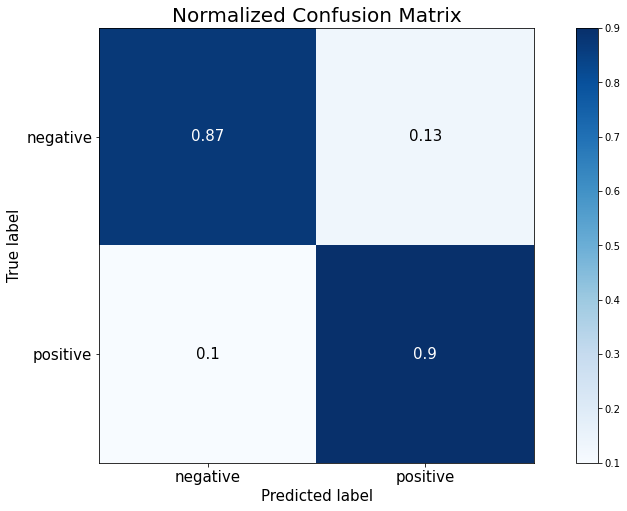

In [ ]:
skplt.metrics.plot_confusion_matrix(test.sentiment.values, y_pred, normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)
plt.show()

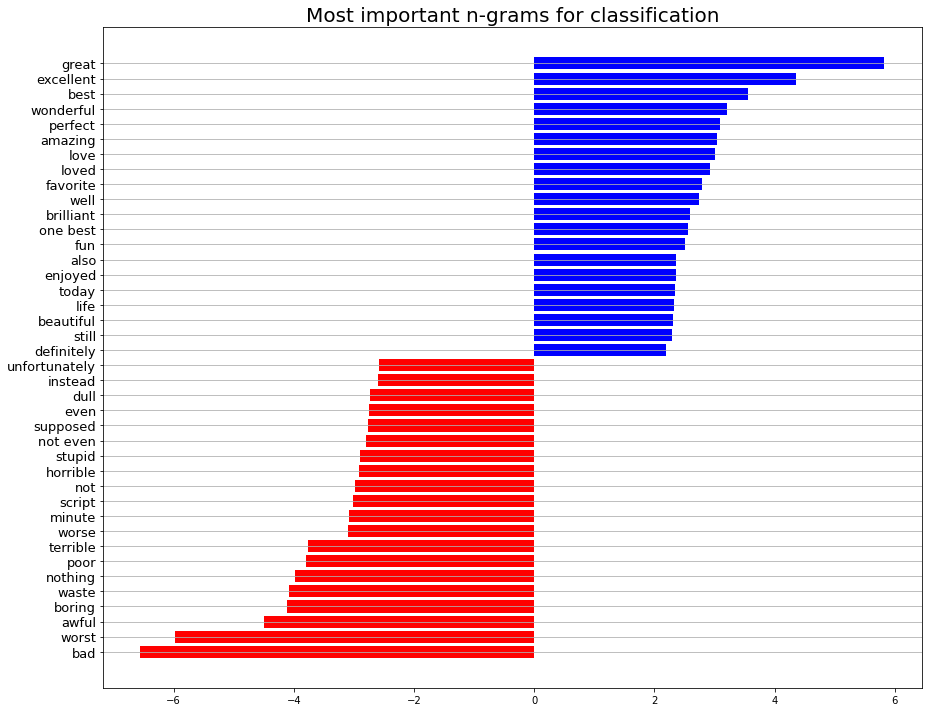

In [ ]:
plot_coeffs(sgd.coef_, vectorizer_lem.get_feature_names())

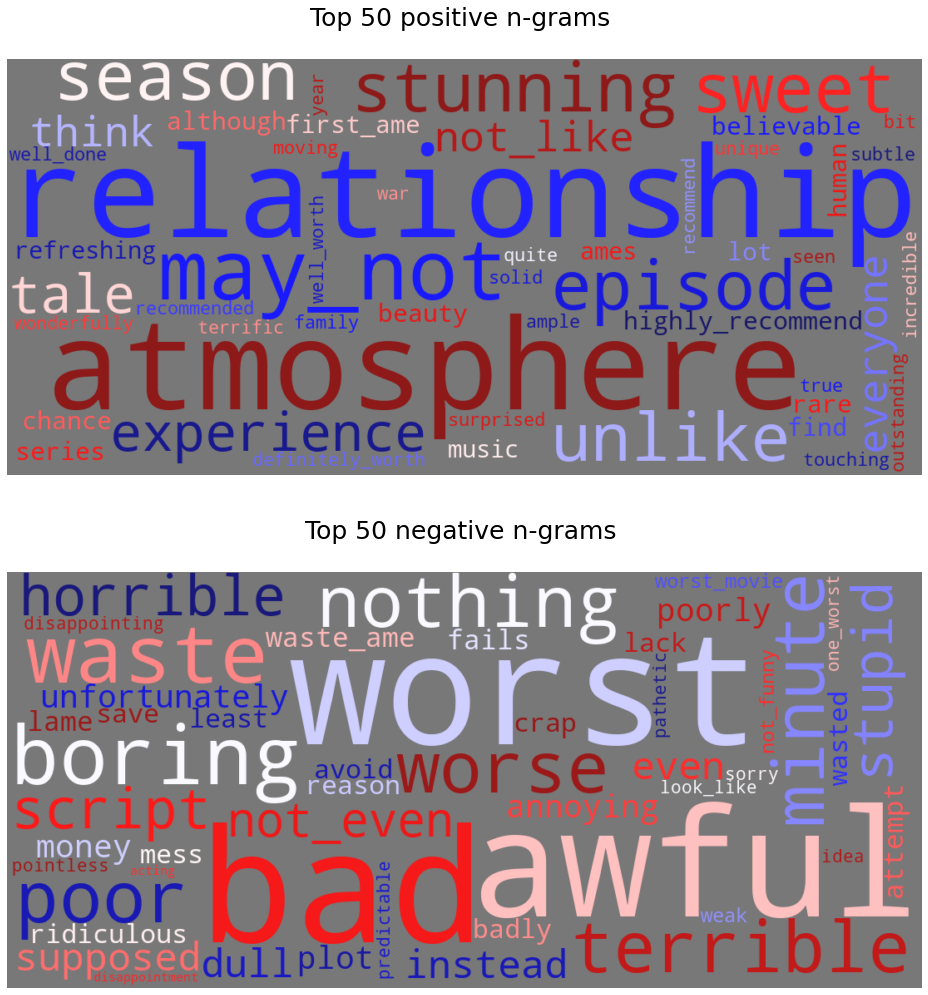

In [ ]:
plot_wordcloud(sgd.coef_, vectorizer_lem.get_feature_names())

Now there are a lot more important single words compared to a lot of n-grams when stamping.

<hr>

### LinearSVC

In [ ]:
svc = CalibratedClassifierCV(LinearSVC(random_state=42))
y_pred, y_probs = classifier_f(svc, vectorizer_lem_train, train.sentiment.values, vectorizer_lem_test)

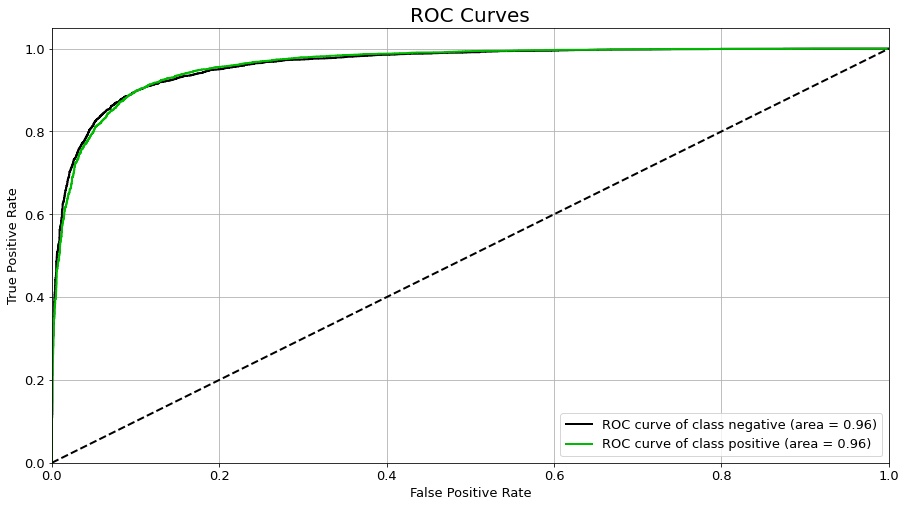

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

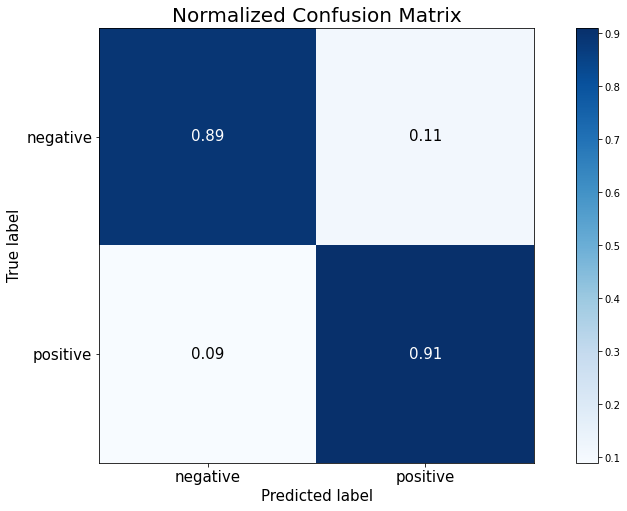

In [ ]:
skplt.metrics.plot_confusion_matrix(test.sentiment.values, y_pred, normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)
plt.show()

In [ ]:
coefs = np.zeros((1,20000))
for i in svc.calibrated_classifiers_:
    coefs += np.array(i.base_estimator.coef_)
    coefs = coefs/3

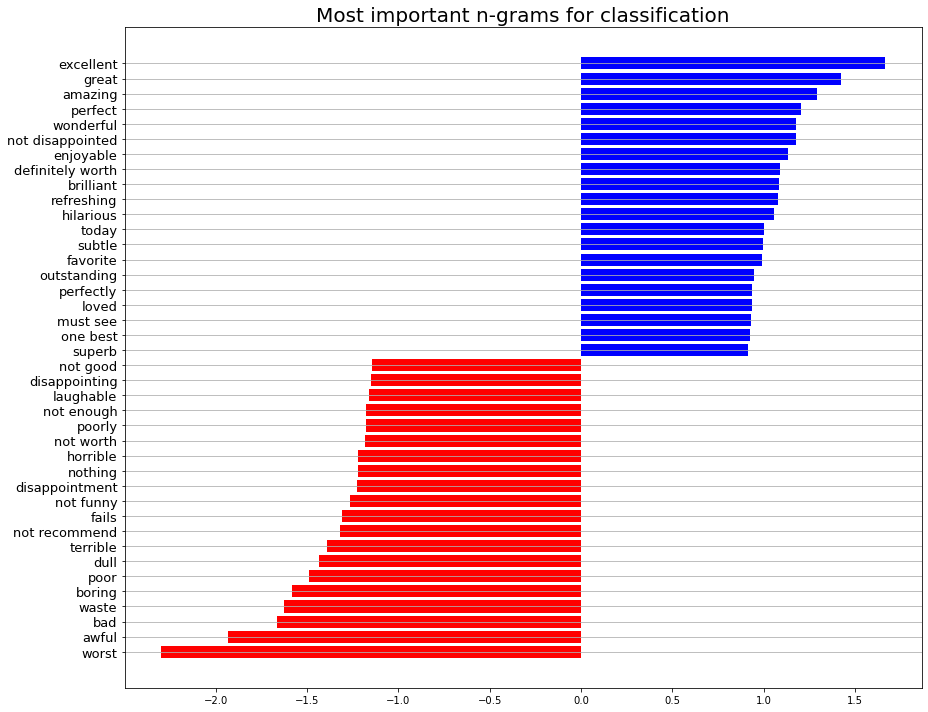

In [ ]:
plot_coeffs(coefs, vectorizer_lem.get_feature_names())

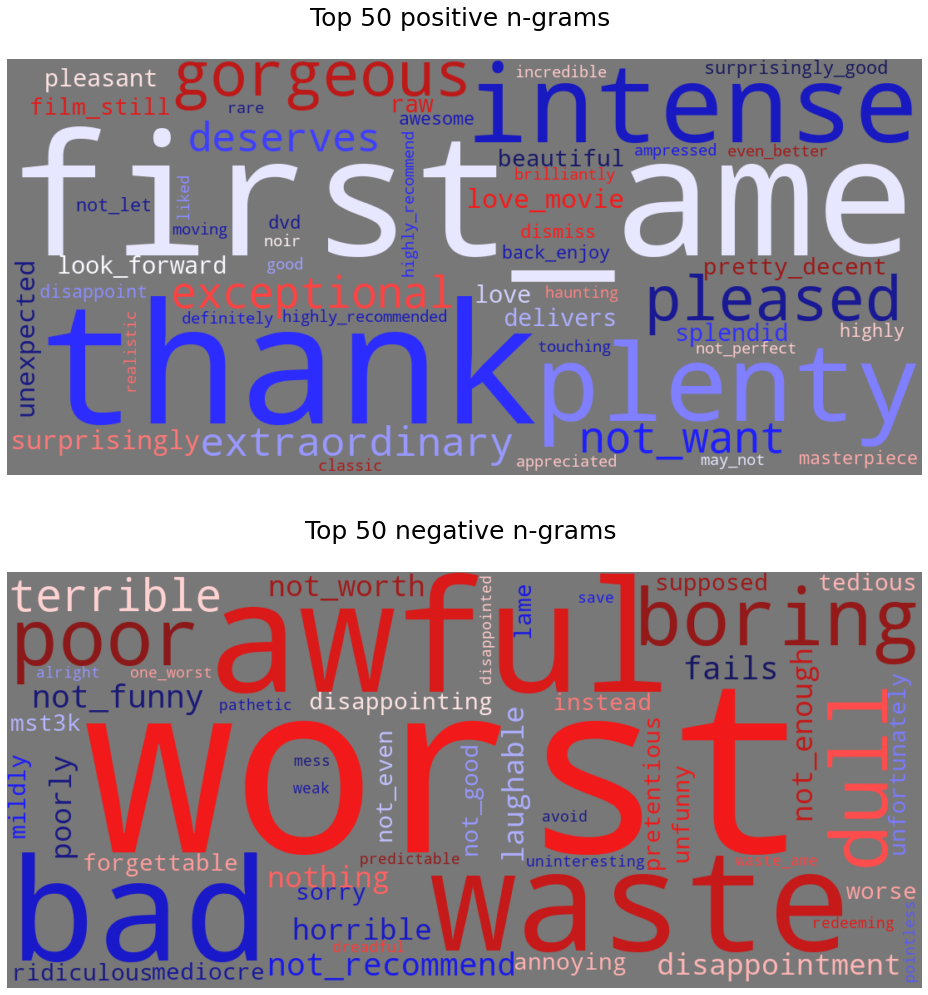

In [ ]:
plot_wordcloud(coefs, vectorizer_lem.get_feature_names())

<hr>

### Naive Bayes

In [ ]:
mnb = MultinomialNB()
y_pred, y_probs = classifier_f(mnb, vectorizer_lem_train, train.sentiment, vectorizer_lem_test)

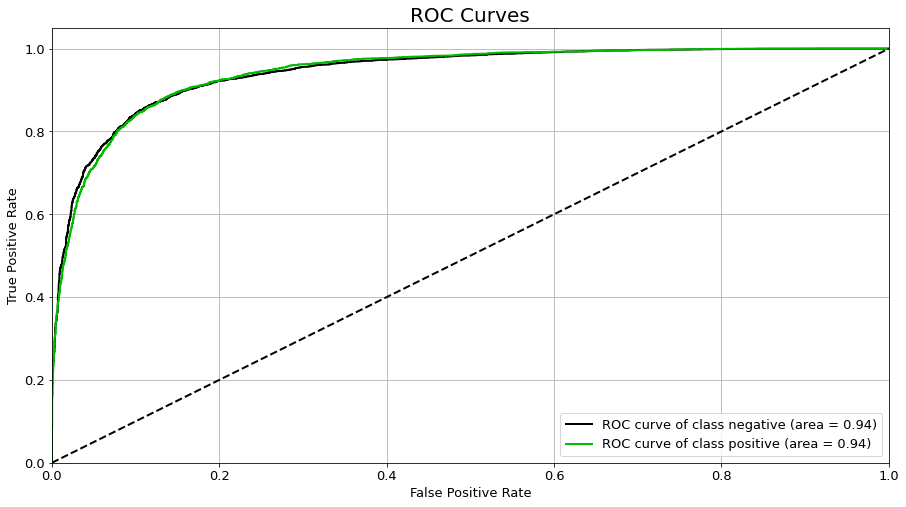

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

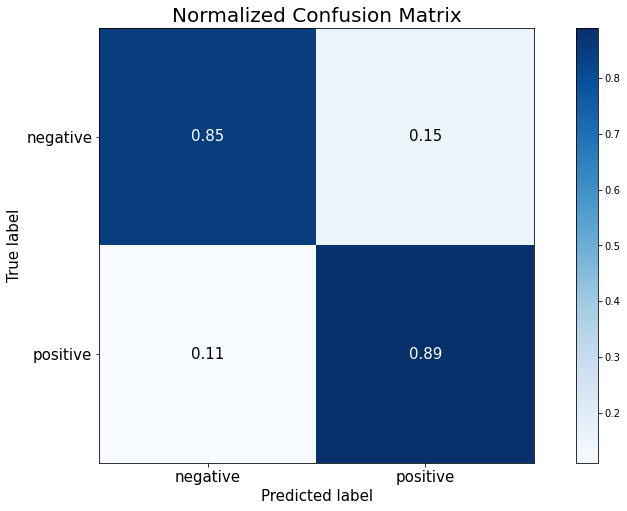

In [ ]:
skplt.metrics.plot_confusion_matrix(test.sentiment.values, y_pred, normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)
plt.show()

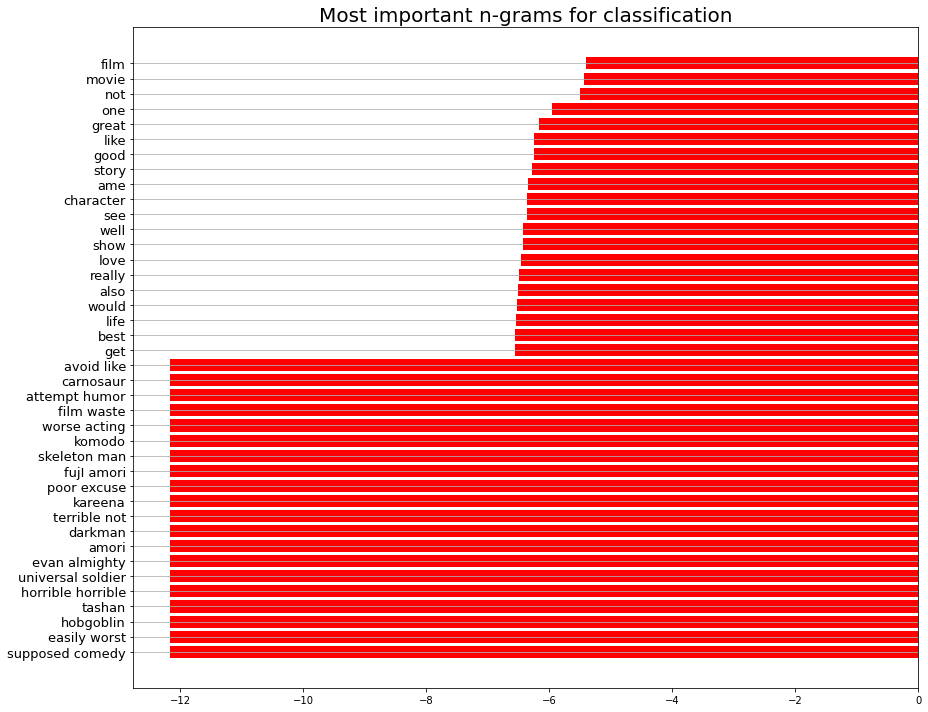

In [ ]:
plot_coeffs(mnb.coef_, vectorizer_lem.get_feature_names())

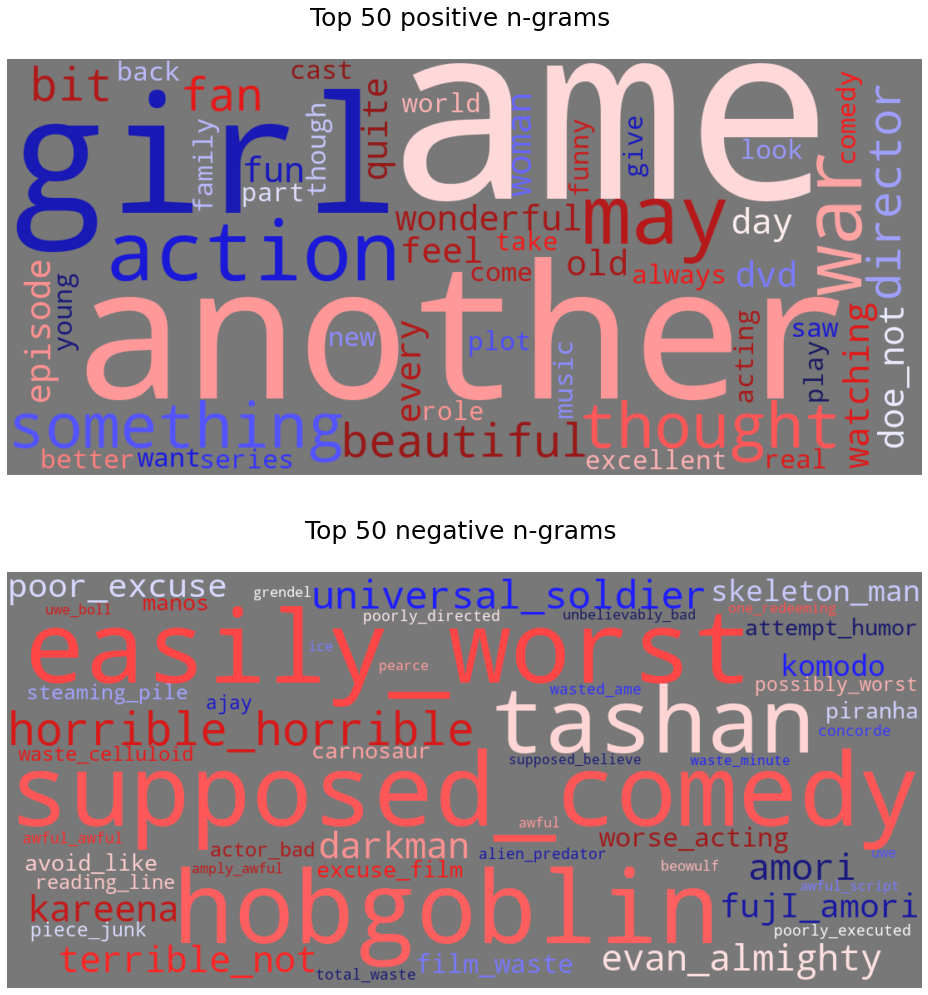

In [ ]:
plot_wordcloud(mnb.coef_, vectorizer_lem.get_feature_names())

ComplementNB:

In [ ]:
cnb = ComplementNB()
y_pred, y_probs = classifier_f(cnb, vectorizer_lem_train, train.sentiment, vectorizer_lem_test)

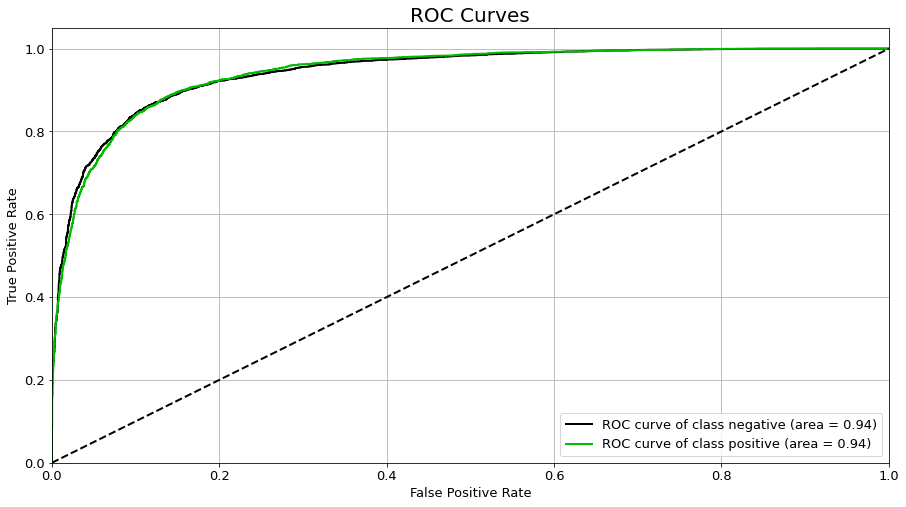

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

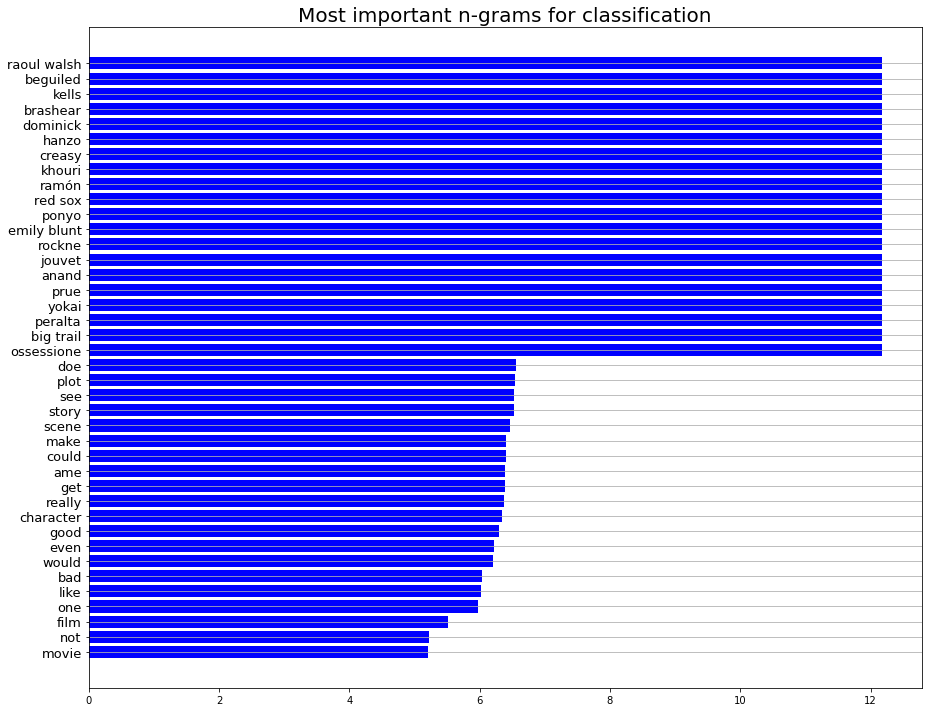

In [ ]:
plot_coeffs(cnb.coef_, vectorizer_lem.get_feature_names())

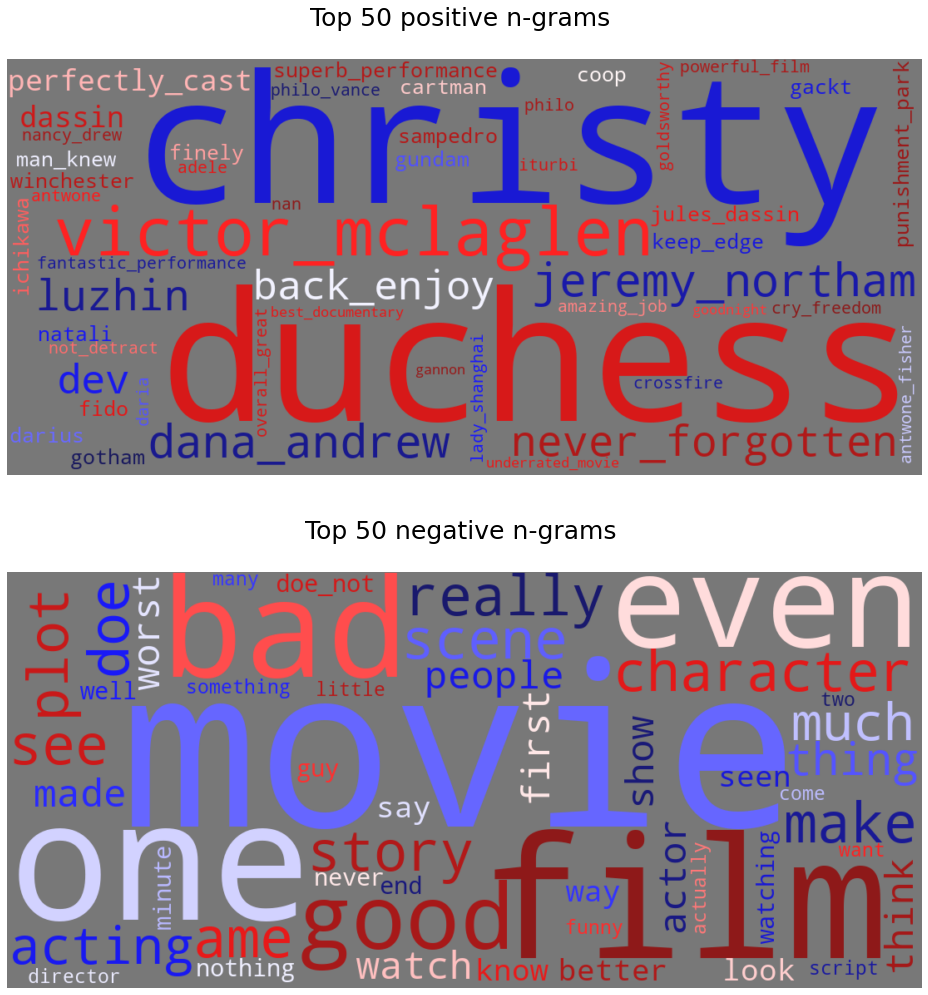

In [ ]:
plot_wordcloud(cnb.coef_, vectorizer_lem.get_feature_names())

In [ ]:
bnb = BernoulliNB()
y_pred, y_probs = classifier_f(bnb, vectorizer_lem_train, train.sentiment, vectorizer_lem_test)

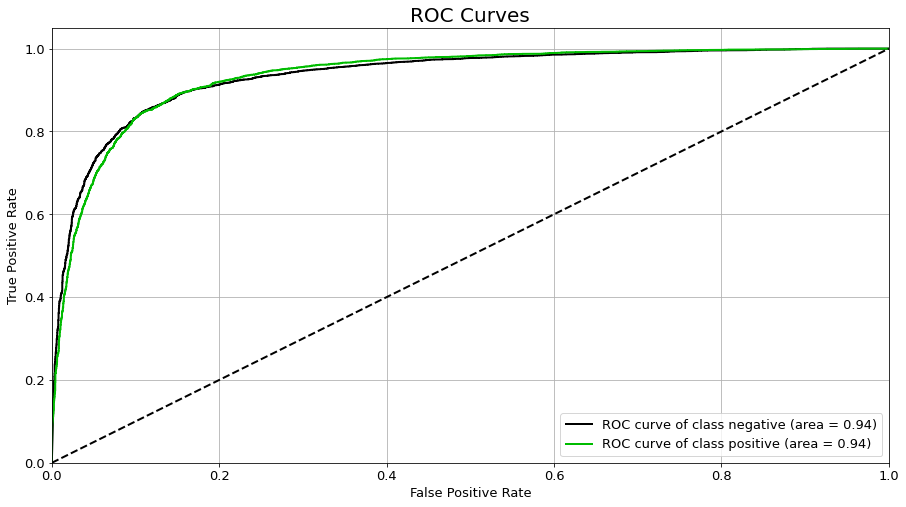

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

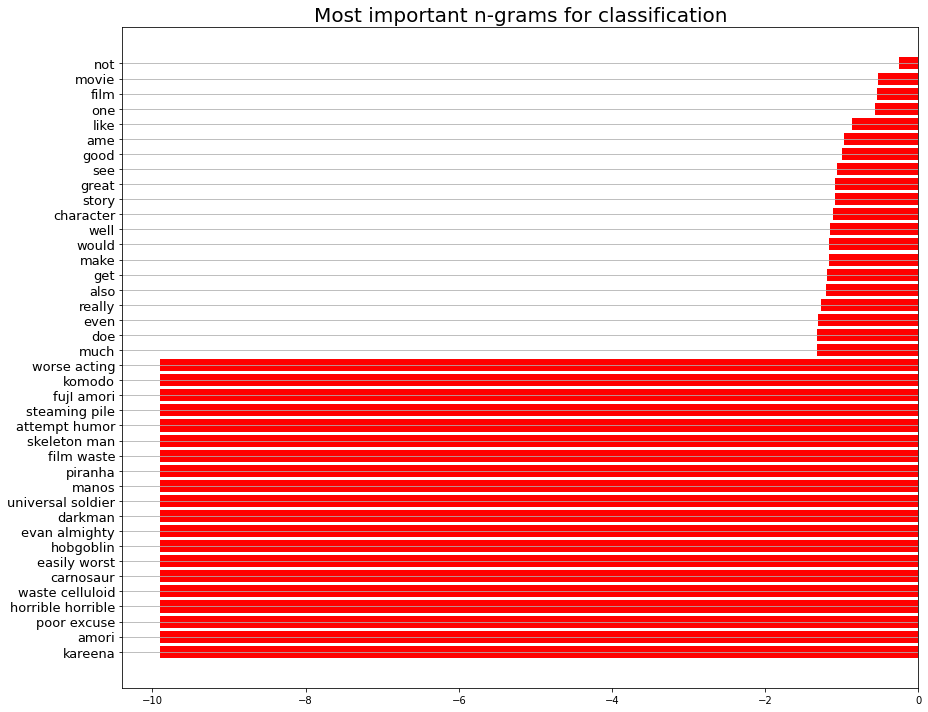

In [ ]:
plot_coeffs(bnb.coef_, vectorizer_lem.get_feature_names())

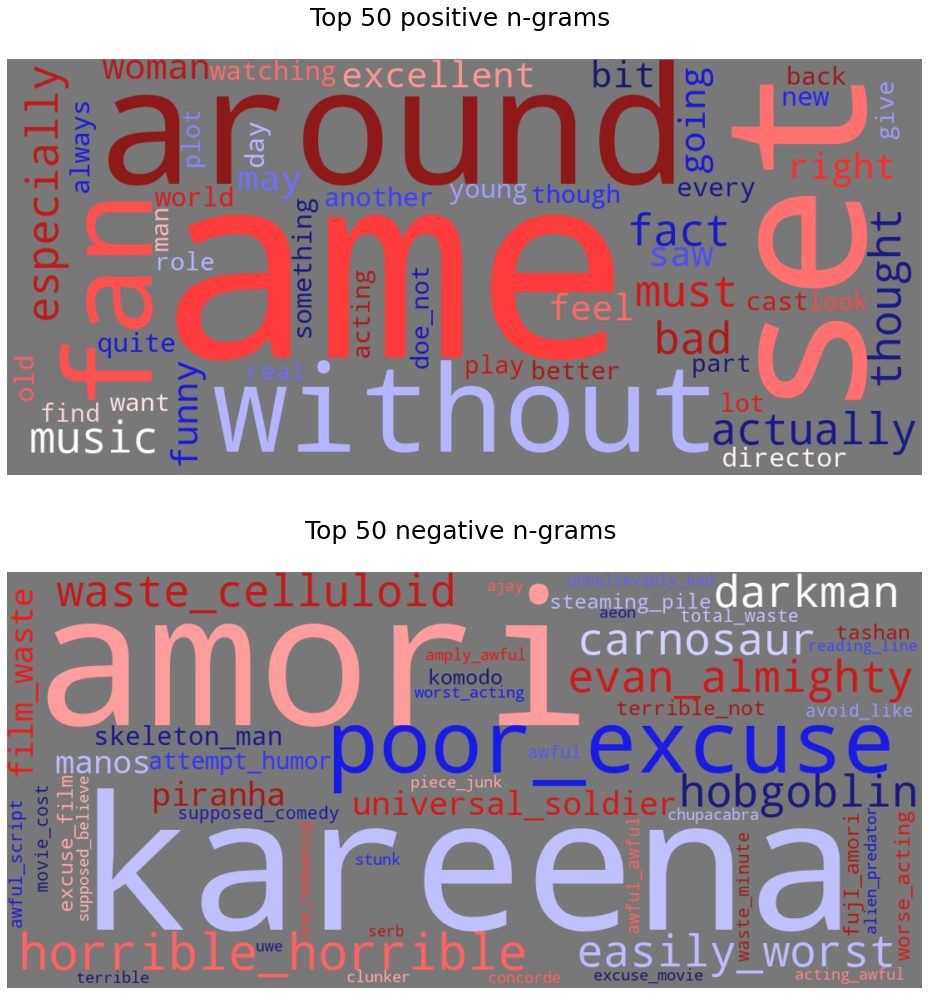

In [ ]:
plot_wordcloud(bnb.coef_, vectorizer_lem.get_feature_names())

* The use of the lemmatizer allowed to improve the classification quality for SGD and LinearSVC algorithms.
* When using the lemmatizer, the interpretability of wordcloud for Bayesian classifiers did not increase.

## Adding sentiment information

In [ ]:
train_pol = train['review'].map(lambda x: TextBlob(x).sentiment[0]).values.reshape(39665,1)
train_subj = train['review'].map(lambda x: TextBlob(x).sentiment[1]).values.reshape(39665,1)
test_pol = test['review'].map(lambda x: TextBlob(x).sentiment[0]).values.reshape(9917,1)
test_subj = test['review'].map(lambda x: TextBlob(x).sentiment[1]).values.reshape(9917,1)

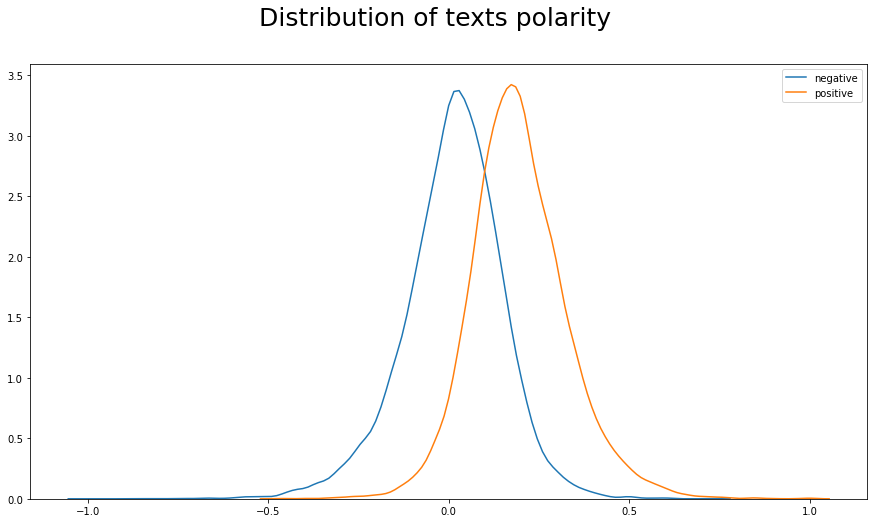

In [ ]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Distribution of texts polarity', fontsize=25)
sns.distplot(train_pol[train.sentiment == 'negative'], label='negative', hist=False)
sns.distplot(train_pol[train.sentiment == 'positive'], label='positive', hist=False)
plt.show()

There is a strong intersection of positive and negative texts, but it is worth trying to use this attribute for classification.

Add two columns with the values of polarity and subjectivity

In [ ]:
vectorizer_lem_train = sparse.hstack((vectorizer_lem_train, sparse.csr_matrix(train_pol), sparse.csr_matrix(train_subj)))
vectorizer_lem_test = sparse.hstack((vectorizer_lem_test, sparse.csr_matrix(test_pol), sparse.csr_matrix(test_subj)))

In [ ]:
scaler = MaxAbsScaler()
scaled_train = scaler.fit_transform(vectorizer_lem_train)
scaled_test = scaler.transform(vectorizer_lem_test)

In [ ]:
sgd = SGDClassifier(random_state=42, loss='log')
y_pred, y_probs = classifier_f(sgd, scaled_train, train.sentiment.values, scaled_test) 

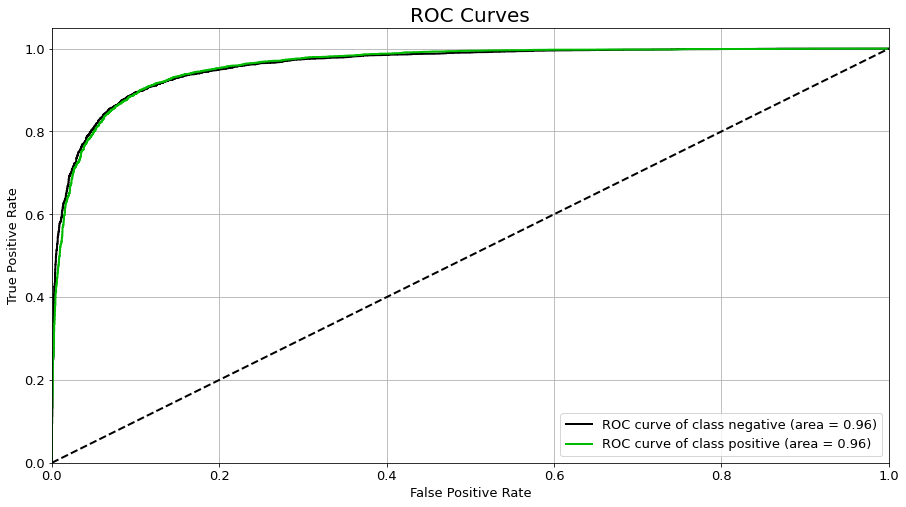

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

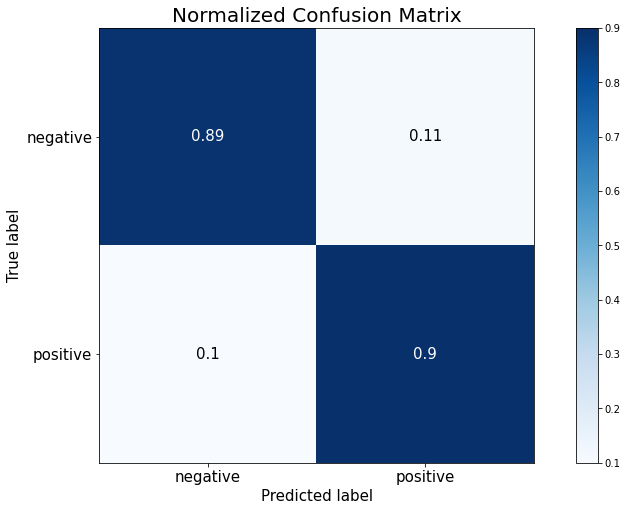

In [ ]:
skplt.metrics.plot_confusion_matrix(test.sentiment.values, y_pred, normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)
plt.show()

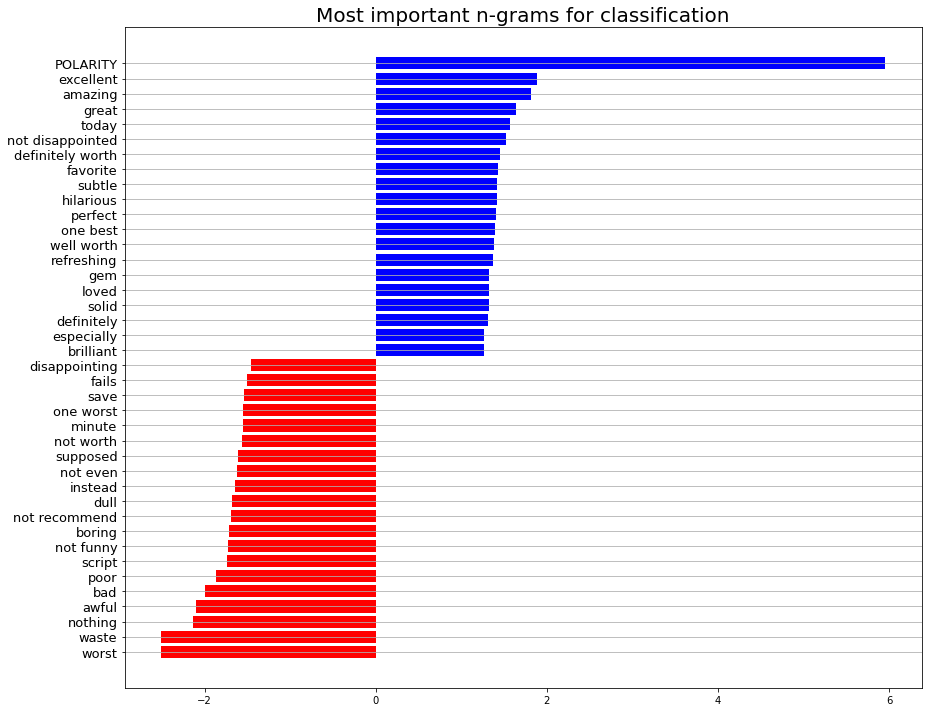

In [ ]:
plot_coeffs(sgd.coef_, vectorizer_lem.get_feature_names() + ['POLARITY', 'SUBJECTIVITY'])

We see that the new sign of polarity has a large coefficient for classifying a positive class.

# Hyperparameters tuning

In [ ]:
grid = {
    'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'l1_ratio': np.linspace(0.01, 1, 10),
    'epsilon': np.linspace(0.1, 1, 5),
    'penalty': ['l2', 'elasticnet']
}

In [ ]:
grid_search = GridSearchCV(estimator=sgd, 
                           param_grid=grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring={'roc': make_scorer(roc_auc_score)},
                           refit='roc',
                           n_jobs=-1, 
                           verbose=10
)

In [ ]:
y = [0 if i == 'negative' else 1 for i in train.sentiment.values]

In [ ]:
y_test = [0 if i == 'negative' else 1 for i in test.sentiment.values]

In [ ]:
sgd_grid = classifier_f(grid_search, scaled_train, y, scaled_test) 

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

In [ ]:
grid_search.best_params_

{'alpha': 0.0001, 'epsilon': 0.1, 'l1_ratio': 0.01, 'penalty': 'l2'}

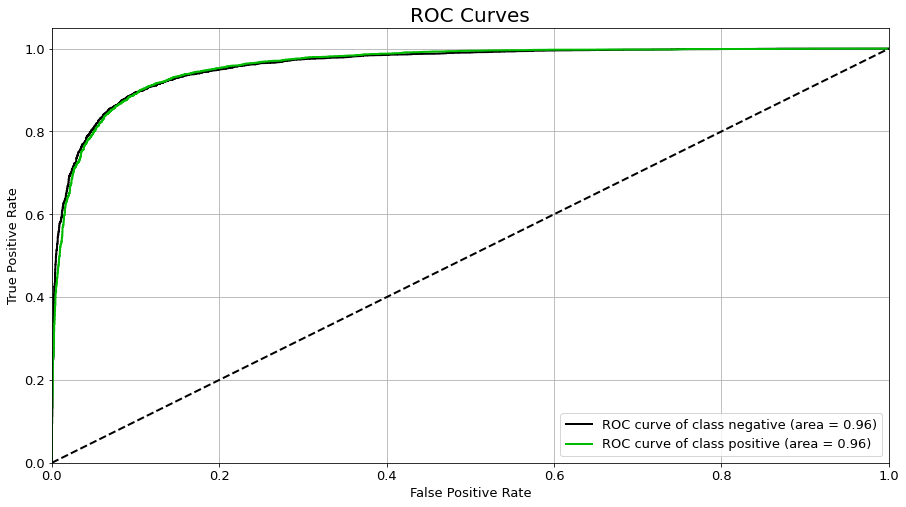

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, sgd_grid[1], plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

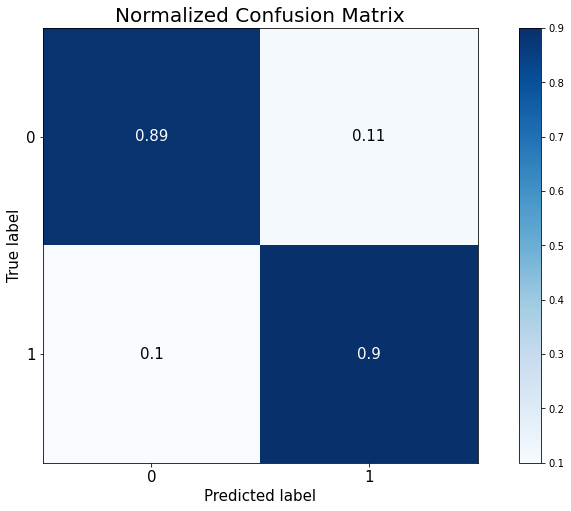

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, sgd_grid[0], normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)
plt.show()

### LinearSVC

In [ ]:
grid = {
    'base_estimator__C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'base_estimator__loss': ['squared_hinge', 'hinge'],
    'base_estimator__penalty': ['l2']
}

In [ ]:
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring={'roc': make_scorer(roc_auc_score)},
                           refit='roc',
                           n_jobs=-1, 
                           verbose=10
)

In [ ]:
svc_grid = classifier_f(grid_search, scaled_train, y, scaled_test) 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   16.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.9s finished


In [ ]:
grid_search.best_params_

{'base_estimator__C': 0.1,
 'base_estimator__loss': 'hinge',
 'base_estimator__penalty': 'l2'}

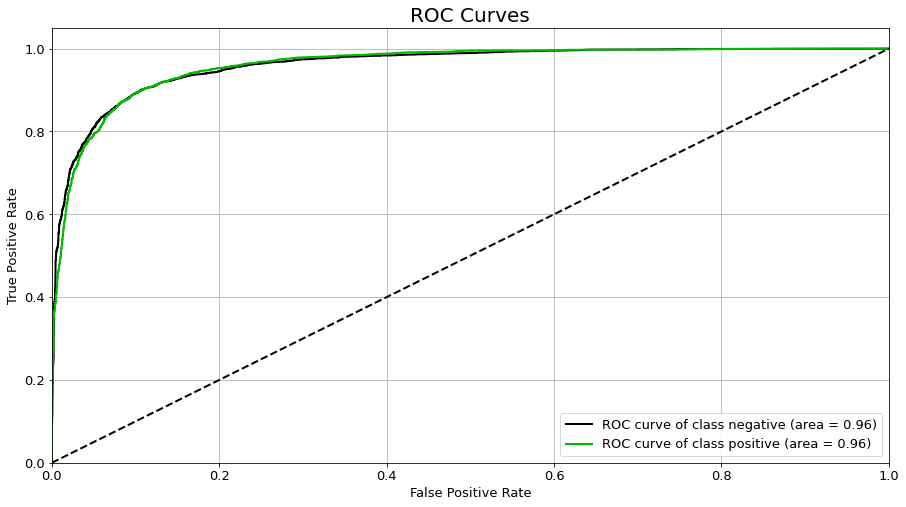

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, svc_grid[1], plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

## Naive Bayes

The alpha hyperparameter setting in the naive Bayes classifier algorithm is set up only on a set of features with a vector representation of our dictionary (without polarity and subjectivity).

In [ ]:
vectorizer_lem_train = sparse.csr_matrix(vectorizer_lem_train)[:, :-2]
vectorizer_lem_test = sparse.csr_matrix(vectorizer_lem_test)[:, :-2]

In [ ]:
grid = {
    'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
}

In [ ]:
grid_search = GridSearchCV(estimator=mnb, 
                           param_grid=grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring={'roc': make_scorer(roc_auc_score)},
                           refit='roc',
                           n_jobs=-1, 
                           verbose=10
)

In [ ]:
mnb_grid = classifier_f(grid_search, vectorizer_lem_train, y, vectorizer_lem_test) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    1.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.4s finished


In [ ]:
grid_search.best_params_

{'alpha': 1.0}

# Only polar vocabulary

In [ ]:
my_dictionary = {k: v for k, v in vectorizer_lem.vocabulary_.items() if TextBlob(k).sentiment[0] != 0}

In [ ]:
len(my_dictionary)

3801

Dimension is greatly reduced. Let's create a new vectorizer and pass our dictionary into it.

In [ ]:
polar_vectorizer = TfidfVectorizer(tokenizer=tokenize_lem, vocabulary=my_dictionary.keys())

In [ ]:
polar_vectorizer_train = polar_vectorizer.fit_transform(train_lst)
polar_vectorizer_test = polar_vectorizer.transform(test_lst)

In [ ]:
sgd = SGDClassifier(random_state=42, loss='log')
y_pred, y_probs = classifier_f(sgd, polar_vectorizer_train, train.sentiment.values, polar_vectorizer_test) 

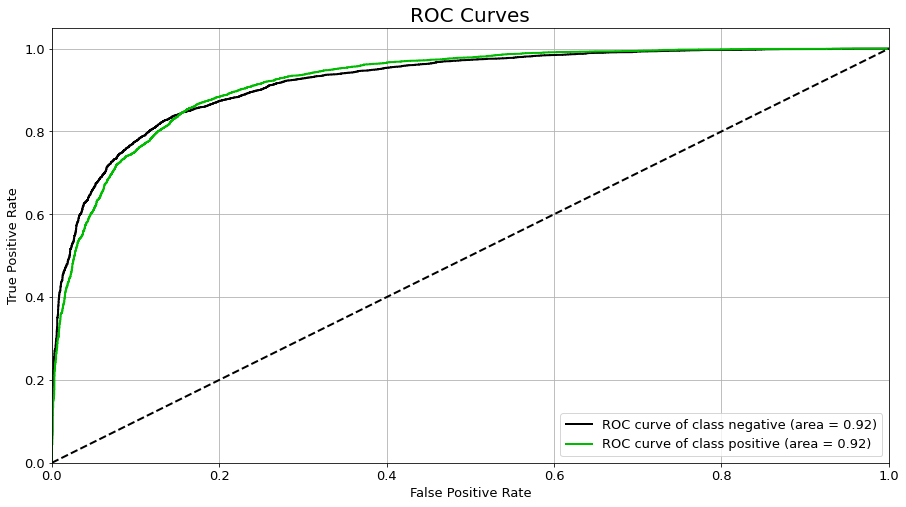

In [ ]:
skplt.metrics.plot_roc(test.sentiment.values, y_probs, plot_micro=False, plot_macro=False, figsize=(15,8), title_fontsize=20, text_fontsize=13)
plt.grid()
plt.show()

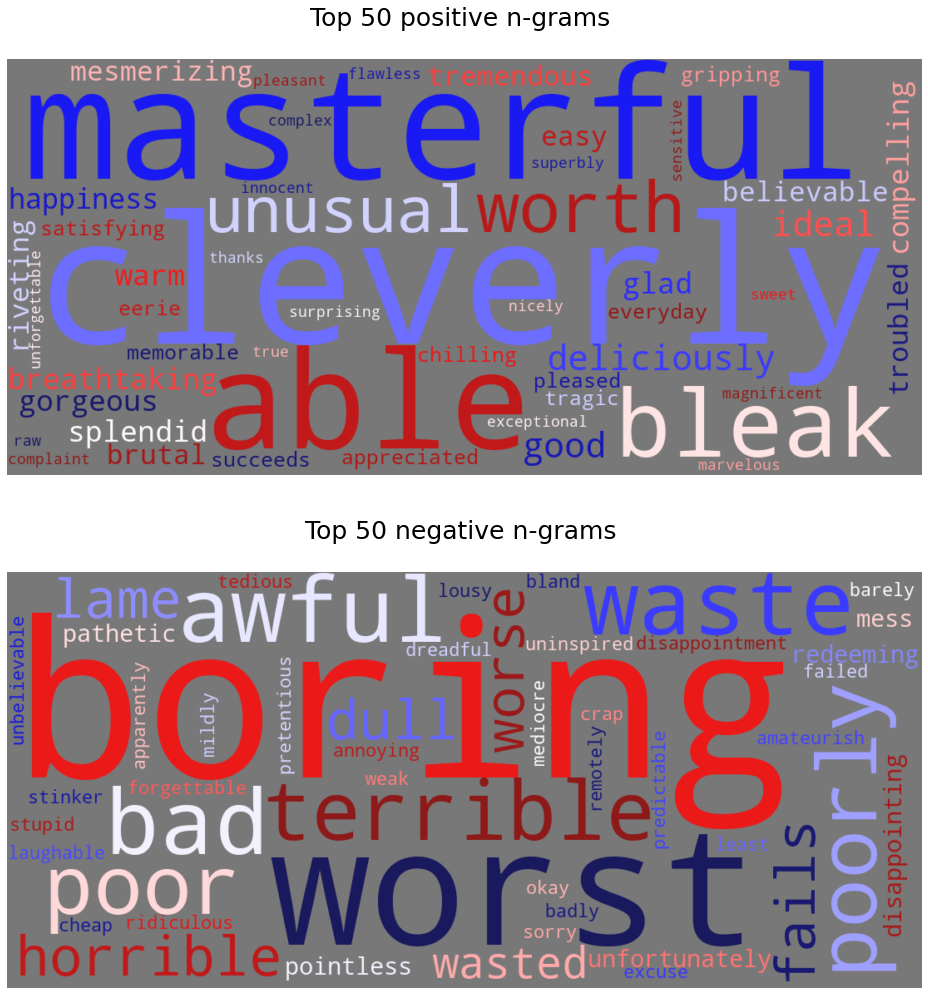

In [ ]:
plot_wordcloud(sgd.coef_, polar_vectorizer.get_feature_names())

In this case, Wordcloud looks as beautiful as possible: in both cases, only brightly colored adjectives remained.

# Summary

* In the work, 3 basic algorithms for classifying texts were tested.
* Words and 2-grams were used as signs, and various approaches to bringing words to a general form (stemming and lemmatization) were also tested.
* In a small amount, the sentiment analysis approach was applied, which gave a slight increase in the classification quality.
* The highest classification result was shown by the SGDClassifier algorithm with 20,000 lemmatized word attributes and 2 signs of polarity and subjectivity.
* It was noted that lemmatization as a whole allows achieving a higher result.
* The SGDClassifier and LinearSVC classifiers allow a better interpretation of the importance of words in the work of the classifier, but this is worse for Bayesian algorithms.

The classification quality of the studied models can probably be improved even further using the word2vec embeddings approach.